In [ ]:


import random, os, math, time, itertools
from pathlib import Path
import cv2, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics import Accuracy, ConfusionMatrix
from torch.cuda.amp import autocast, GradScaler
torch.manual_seed(42);  np.random.seed(42);  random.seed(42)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running on', DEVICE)


Running on cuda


In [ ]:

DATA_ROOT     = Path('/mnt/c/Users/ezycloudx-admin/Documents/big-data/Complete Dataset')   # train/ , val/ sub-dirs
IMG_SIZE      = 112        # as in paper
CLIP_LEN      = 10         # frames
SEGMENTS      = 1          # contiguous clip
BATCH_SIZE    = 8
EPOCHS        = 100
LR_INIT       = 1e-3
WD            = 1e-5
PATIENCE_ES   = 10         # early stop
PATIENCE_LR   = 5
LR_DROP       = 0.5
NUM_WORKERS   = 4

In [ ]:

def sample_clip(video_path:Path, num_frames=CLIP_LEN):
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f'Cannot open {video_path}')
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if length < num_frames:
        indices = list(range(length)) + [length-1]*(num_frames-length)
    else:
        start = random.randint(0, length-num_frames)
        indices = list(range(start, start+num_frames))
    frames=[]
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, frame = cap.read()
        if not ok: frame = frames[-1]
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frames.append(frame)
    cap.release()
    return np.stack(frames)            # (T,H,W,3)


In [ ]:

import albumentations as A
RGB_TRAIN = A.Compose([
    A.HorizontalFlip(p=.5),
    A.ColorJitter(.1,.1,.1,.1,p=.6),
    A.Normalize(mean=(0.485,0.456,0.406),
                std=(0.229,0.224,0.225))
])
RGB_VAL   = A.Compose([
    A.Normalize(mean=(0.485,0.456,0.406),
                std=(0.229,0.224,0.225))
])

TRAIN_DIR = DATA_ROOT/'train'; VAL_DIR = DATA_ROOT/'val'
CLASS_NAMES = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
NUM_CLASSES = len(CLASS_NAMES)
print('Classes:', CLASS_NAMES)

def gather(root):
    exts = ('*.mp4','*.avi','*.mkv','*.flv','*.webm')
    lst=[]
    for cname in CLASS_NAMES:
        for e in exts:
            lst += [(p, CLASS_NAMES.index(cname)) for p in (root/cname).glob(e)]
    random.shuffle(lst);  return lst

class ViolenceDS(Dataset):
    def __init__(self, samples, aug):
        self.samples=samples; self.aug=aug
    def __len__(self): return len(self.samples)
    def __getitem__(self,idx):
        path,y = self.samples[idx]
        clip   = sample_clip(path)                      # (T,H,W,3)
        clip   = np.stack([self.aug(image=f)['image'] for f in clip])
        clip   = torch.from_numpy(clip).permute(0,3,1,2).float()
        return clip, y

train_samp = gather(TRAIN_DIR); val_samp = gather(VAL_DIR)
train_ds = ViolenceDS(train_samp, RGB_TRAIN)
val_ds   = ViolenceDS(val_samp,   RGB_VAL)
train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)


Classes: ['Fight', 'HockeyFight', 'MovieFights', 'NonFight']


In [ ]:

class TemporalShift(nn.Module):
    def __init__(self,n_div=4): super().__init__(); self.n_div=n_div
    def forward(self,x):                            # (B,T,C,H,W)
        B,T,C,H,W = x.size(); f=C//self.n_div
        out = torch.zeros_like(x)
        out[:,1:,:f]     = x[:,:-1,:f]
        out[:,:-1,f:2*f] = x[:,1:,f:2*f]
        out[:,:,2*f:]    = x[:,:,2*f:]
        return out


In [ ]:

import timm

# ---- revised Bi-LTMA -------------------------------------------
class BiLTMA(nn.Module):
    def __init__(self, ch, r=2):
        super().__init__()
        self.reduce  = nn.Conv2d(ch, ch//r, 1, bias=False)
        self.offset  = nn.Conv2d(ch//r, ch//r, 3, padding=1, bias=False)
        self.restore = nn.Conv2d(ch//r*2, ch, 1, bias=False)

    def forward(self, feat):                # feat (B,T,C,H,W)
        B, T, C, H, W = feat.size()

        # 1) channel squeeze  -------------------------------
        f = self.reduce(feat.view(B*T, C, H, W))            # (B*T,C',H,W)
        C_ = f.size(1)
        f = f.view(B, T, C_, H, W)

        # 2) forward / backward frame diffs -----------------
        f_fwd = self.offset(f[:, 1:].reshape(-1, C_, H, W)) \
                .view(B, T-1, C_, H, W) - f[:, :-1]          # (B,T-1,C',H,W)
        f_bwd = self.offset(f[:, :-1].reshape(-1, C_, H, W)) \
                .view(B, T-1, C_, H, W) - f[:, 1:]

        pad = torch.zeros_like(f_fwd[:, :1])
        f_fwd = torch.cat([f_fwd, pad], dim=1)   # (B,T,C',H,W)
        f_bwd = torch.cat([pad,  f_bwd], dim=1)

        # 3) concat → restore channels → sigmoid mask -------
        att = torch.sigmoid(
                self.restore(
                    torch.cat([f_fwd, f_bwd], dim=2)    # (B,T,2C',H,W)
                          .view(B*T, 2*C_, H, W)
                )).view(B, T, C, H, W)

        return att * feat                                # gated features


class Head(nn.Module):
    def __init__(self, in_ch, n_cls):
        super().__init__()
        self.lstm = nn.LSTM(in_ch, 64, bidirectional=True,
                            batch_first=True)
        self.att  = nn.Linear(128,1)
        self.fc   = nn.Linear(128, n_cls)
    def forward(self,x):            # (B,T,C)
        h,_ = self.lstm(x);  α = torch.softmax(torch.tanh(self.att(h)),1)
        ctx = (α*h).sum(1)
        return self.fc(ctx)

class MobileNetV3_BiLTMA(nn.Module):
    def __init__(self, n_cls=NUM_CLASSES):
        super().__init__()
        self.backbone = timm.create_model('mobilenetv3_small_050',
                                          pretrained=True, features_only=True,
                                          out_indices=[-1])
        ch = self.backbone.feature_info.channels()[-1]      # 288
        self.tsm   = TemporalShift(4)
        self.pool  = nn.AdaptiveAvgPool2d(1)
        self.biltma= BiLTMA(ch)
        self.head  = Head(ch, n_cls)
    def forward(self,x):             # (B,T,C,H,W)
        B,T,C,H,W = x.shape
        x = self.tsm(x).view(B*T,C,H,W)
        # ---- single-line tweak in MobileNetV3_BiLTMA.forward ------------
        f = self.backbone(x)[0]                        # (B*T,288,h,w)
        f = self.pool(f).view(B, T, -1, 1, 1)          # keep as 5-D
        f = self.biltma(f).squeeze(-1).squeeze(-1)     # apply LTMA ▶ (B,T,288)

        return self.head(f)

model = MobileNetV3_BiLTMA().to(DEVICE)
print('Params:', sum(p.numel() for p in model.parameters())/1e6, 'M')


Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Params: 0.765221 M


In [ ]:

criterion = nn.CrossEntropyLoss()
acc_metric     = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(DEVICE)
confmat_metric = ConfusionMatrix(task='multiclass', num_classes=NUM_CLASSES).to(DEVICE)


In [ ]:

def train_epoch(model, loader, opt, scaler):
    model.train();  acc_metric.reset();  run=0
    for clips, y in tqdm(loader, leave=False):
        clips, y = clips.to(DEVICE), y.to(DEVICE)
        with autocast():
            out = model(clips);  loss = criterion(out, y)
        opt.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
        run += loss.item()*clips.size(0); acc_metric.update(out,y)
    return run/len(loader.dataset), acc_metric.compute().item()

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval();  acc_metric.reset(); confmat_metric.reset(); run=0
    for clips, y in tqdm(loader, leave=False):
        clips, y = clips.to(DEVICE), y.to(DEVICE)
        with autocast(): out = model(clips); loss = criterion(out,y)
        run += loss.item()*clips.size(0)
        acc_metric.update(out,y); confmat_metric.update(out,y)
    return run/len(loader.dataset), acc_metric.compute().item(), confmat_metric.compute()


/tmp/ipykernel_1064380/2923480458.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/324 [00:00<?, ?it/s]/tmp/ipykernel_1064380/3446479923.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
  0%|          | 0/86 [00:00<?, ?it/s]           /tmp/ipykernel_1064380/3446479923.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): out = model(clips); loss = criterion(out,y)


Epoch 001: train_acc=0.643  val_acc=0.745  lr=1.00e-03
  ✅ best model saved


Epoch 002: train_acc=0.735  val_acc=0.688  lr=1.00e-03


Epoch 003: train_acc=0.761  val_acc=0.575  lr=1.00e-03


Epoch 004: train_acc=0.793  val_acc=0.676  lr=1.00e-03


Epoch 005: train_acc=0.803  val_acc=0.728  lr=1.00e-03


Epoch 006: train_acc=0.811  val_acc=0.693  lr=1.00e-03


Epoch 007: train_acc=0.820  val_acc=0.693  lr=1.00e-03


Epoch 008: train_acc=0.838  val_acc=0.739  lr=1.00e-03


Epoch 009: train_acc=0.845  val_acc=0.708  lr=1.00e-03


Epoch 010: train_acc=0.858  val_acc=0.661  lr=1.00e-03


Epoch 011: train_acc=0.857  val_acc=0.699  lr=5.00e-04
Early stopping 🔚


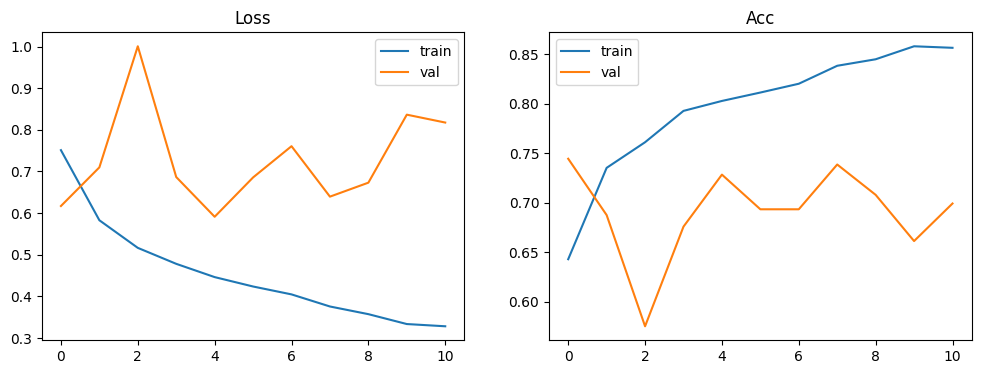

Confusion matrix:
 [[178   0  22  75]
 [  0  98   1   1]
 [  0   0  33   2]
 [ 75   9  21 170]]


In [ ]:

scaler = GradScaler()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR_INIT, weight_decay=WD)
scheduler = ReduceLROnPlateau(
    optimizer,
    factor=LR_DROP,
    patience=PATIENCE_LR
)

best_acc, epochs_no_improve = 0, 0
hist={'tl':[],'vl':[],'ta':[],'va':[]}

for epoch in range(1, EPOCHS+1):
    tl,ta = train_epoch(model,train_loader,optimizer,scaler)
    vl,va,cm = eval_epoch(model,val_loader)
    scheduler.step(vl)

    hist['tl'].append(tl); hist['vl'].append(vl)
    hist['ta'].append(ta); hist['va'].append(va)
    print(f'Epoch {epoch:03d}: train_acc={ta:.3f}  val_acc={va:.3f}  '
          f'lr={optimizer.param_groups[0]["lr"]:.2e}')

    if va > best_acc:
        best_acc = va; epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_biltma.pt')
        print('  ✅ best model saved')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE_ES:
            print('Early stopping 🔚'); break

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.title('Loss'); plt.plot(hist['tl'],label='train'); plt.plot(hist['vl'],label='val'); plt.legend()
plt.subplot(1,2,2); plt.title('Acc');  plt.plot(hist['ta'],label='train'); plt.plot(hist['va'],label='val'); plt.legend(); plt.show()
print('Confusion matrix:\n', cm.cpu().numpy())


In [131]:
# ================================================================
# 📊 Cell 10 — Classification report
# ================================================================
from sklearn.metrics import classification_report
model.load_state_dict(torch.load('best_biltma.pt')); model.eval()
y_true,y_pred=[],[]
with torch.no_grad():
    for clips,y in val_loader:
        logits = model(clips.to(DEVICE))
        y_pred+= torch.argmax(logits,1).cpu().tolist(); y_true+=y.tolist()
print(classification_report(y_true,y_pred,target_names=CLASS_NAMES))


              precision    recall  f1-score   support

       Fight       0.69      0.95      0.80       275
 HockeyFight       0.79      0.97      0.87       100
 MovieFights       0.49      0.77      0.60        35
    NonFight       0.94      0.44      0.60       275

    accuracy                           0.74       685
   macro avg       0.73      0.78      0.72       685
weighted avg       0.80      0.74      0.72       685



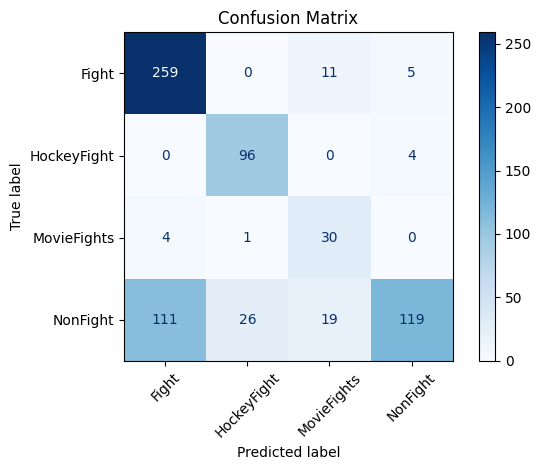

In [134]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False)
plt.tight_layout()
plt.show()